In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from boruta.boruta_py import BorutaPy # boruta requer numpy 1.23.1 ou abaixo
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

In [27]:
# Carregamento dos dados
dataset = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [28]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [29]:
# Converter TotalCharges para float
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [30]:
# verificar nan em dataset
display(dataset.isna().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [31]:
# Remover a coluna 'customerID'
dataset.drop('customerID', axis=1, inplace=True)

# Selecionar colunas categóricas, mantendo as colunas do tipo int e float no DataFrame
categorical_cols = dataset.select_dtypes(include=['object']).columns.tolist()

# Criar um DataFrame com as colunas categóricas aplicando label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() 
dataset_dummies = dataset.copy()
for col in categorical_cols:
    dataset_dummies[col] = label_encoder.fit_transform(dataset[col])

# Separar as features e o target
scaler = StandardScaler()
features_scaled = scaler.fit_transform(dataset_dummies.drop('TotalCharges', axis=1))  # remove 'TotalCharges' from the features

# Após a normalização, a coluna 'TotalCharges' é adicionada de volta ao array de features
features_scaled = np.column_stack((features_scaled, dataset_dummies['TotalCharges']))

imputer = KNNImputer(n_neighbors=10) # Usa o KNN para preencher os valores faltantes
features_imputed = imputer.fit_transform(features_scaled)

# Adicionar 'TotalCharges' como última coluna
dataset['TotalCharges'] = features_imputed[:, -1]

In [32]:
dataset_dummies.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [33]:
# Criar um DataFrame com as colunas categóricas aplicando label encoding
dataset_dummies = dataset.copy()
for col in categorical_cols:
    dataset_dummies[col] = label_encoder.fit_transform(dataset[col])

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn'], axis=1)  # Características
y = dataset_dummies['Churn'] 

In [34]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# XGBoost

In [35]:
# Configuração do modelo XGBoost
xg_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.5,
    objective='binary:logistic',
    random_state=42
)

In [36]:
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8099290780141843
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       511
           1       0.70      0.54      0.61       194

    accuracy                           0.81       705
   macro avg       0.77      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705



# Rede neural

In [38]:
# Define the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)), 
    Dropout(0.3), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(1, activation='sigmoid') 
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Print the model summary
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               2560      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [39]:
# Convert data types
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [40]:
history = nn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1,verbose=0) # verbose=0 to turn off the output

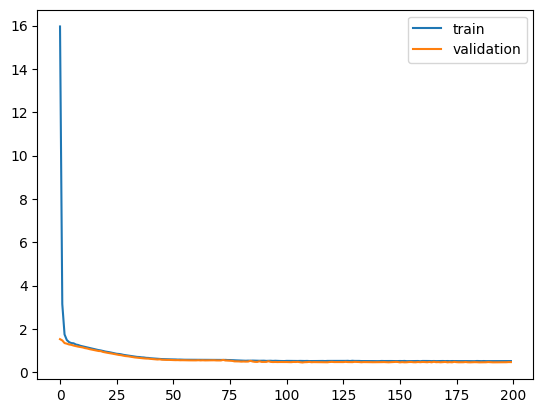

In [41]:
# plotar a curva de perda de um modo
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [42]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7816
Test Accuracy: 0.7815603017807007


In [43]:
# Classification report
predictions = nn_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, predictions))

23/23 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86       511
         1.0       0.70      0.36      0.48       194

    accuracy                           0.78       705
   macro avg       0.75      0.65      0.67       705
weighted avg       0.77      0.78      0.76       705



# Ensemble

In [22]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

23/23 [==============================] - 0s 2ms/step


In [23]:
# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

In [24]:
# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

Ensemble Accuracy: 0.8070921985815603


In [25]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.87       511
         1.0       0.72      0.49      0.58       194

    accuracy                           0.81       705
   macro avg       0.77      0.71      0.73       705
weighted avg       0.80      0.81      0.79       705



# Dataset desbalanceado

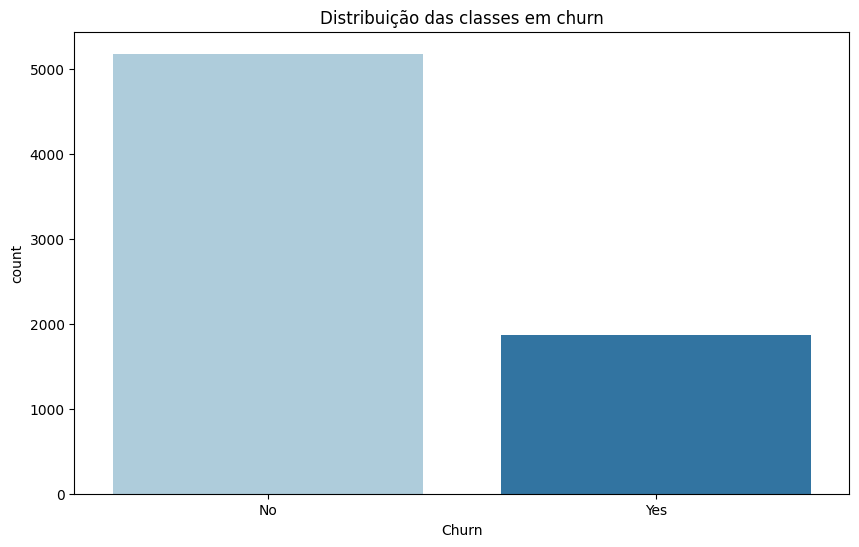

In [23]:
# Gráfico da Distribuição das classes em churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=dataset, palette='Paired', legend=False, hue='Churn')
plt.title('Distribuição das classes em churn')
plt.show()

A classificação desequilibrada é um problema comum no aprendizado de máquina, especialmente no domínio da classificação binária. Isso ocorre quando o conjunto de dados de treinamento tem uma distribuição desigual de classes, levando a um possível viés no modelo treinado. É importante abordar o desequilíbrio de classes para melhorar o desempenho do nosso modelo e garantir sua precisão.

## Modificando os Pesos na Função de Perda

A atribuição de pesos diferentes aos exemplos na função de perda pode ajudar a compensar o desequilíbrio. Isso significa dar maior importância aos exemplos da classe minoritária durante o treinamento do modelo.

**`(y_train == 1).sum()`**: Este trecho conta quantas vezes a classe `1` aparece no conjunto de dados de treino. Isso é feito comparando cada elemento de `y_train` com `1` (verdadeiro onde a condição é atendida) e somando esses valores verdadeiros.

**`(y_train == 0).sum()`**: Similarmente, este trecho conta quantas vezes a classe `0` aparece em `y_train`.

**Divisão**: A divisão do número de exemplos da classe minoritária (1) pelo número de exemplos da classe majoritária(0) calcula um fator de peso. Esse peso será usado para equilibrar as classes, aumentando a importância das instâncias da classe minoritária durante o treinamento do modelo.

In [24]:
# Calculando os pesos para cada classe
weights = (y_train == 1).sum() / (1.0 * (y_train == 0).sum())

xg_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01, 
    max_depth=5,         # Quantidade de camadas, quanto mais camadas, mais complexo
    subsample=0.7,       # Quantidade de amostras por árvore, quanto menos amostras, mais rápido
    colsample_bytree=0.7,# Quantidade de colunas por árvore, quanto menos colunas, mais rápido
    reg_alpha=0.01,      # Regularização L1
    reg_lambda=1.0,      # Regularização L2
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=weights
)

# Treinamento do modelo
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.7801418439716312
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.87       511
         1.0       0.85      0.24      0.38       194

    accuracy                           0.78       705
   macro avg       0.81      0.61      0.62       705
weighted avg       0.80      0.78      0.73       705



In [26]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

23/23 [==============================] - 0s 1ms/step
Ensemble Accuracy: 0.7659574468085106


In [27]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86       511
         1.0       0.85      0.18      0.30       194

    accuracy                           0.77       705
   macro avg       0.81      0.58      0.58       705
weighted avg       0.79      0.77      0.71       705



### Análise de Classe
- **Classe 0 (Majoritária)**
  - **Precisão**: 0.80. Isso indica que 80% das previsões para classe 0 estão corretas.
  - **Recall**: 0.97. Significa que 97% das instâncias reais de classe 0 foram identificadas corretamente pelo modelo.
  - **F1-Score**: 0.87. O F1-score é uma média harmônica de precisão e recall, e um valor de 0.87 sugere um bom equilíbrio entre precisão e recall para esta classe.
  - **Suporte**: 511. Número total de casos reais da classe 0 no conjunto de teste.

- **Classe 1 (Minoritária)**
  - **Precisão**: 0.81. Isto sugere que 81% das previsões de classe 1 pelo modelo estão corretas.
  - **Recall**: 0.35. Apenas 37% das instâncias reais de classe 1 foram identificadas corretamente, o que é bastante baixo.
  - **F1-Score**: 0.49. Este valor mais baixo indica uma baixa eficácia do modelo em equilibrar a precisão e o recall para a classe minoritária.
  - **Suporte**: 194. Número total de casos reais da classe 1 no conjunto de teste.

### Análise Agregada
- **Acurácia**: 0.80. Isso mostra que o modelo acertou 80% das vezes para todas as previsões feitas.
- **Média Macro (avg)**:
  - **Precisão**: 0.80. Média simples das precisões para ambas as classes.
  - **Recall**: 0.66. Média simples dos recalls, afetada negativamente pelo baixo recall da classe 1.
  - **F1-Score**: 0.68. Indica a média do F1-score, que também é puxada para baixo pela performance na classe 1.
- **Média Ponderada (weighted avg)**:
  - **Precisão**: 0.80. Considera o número de instâncias em cada classe, dando mais peso à classe 0.
  - **Recall**: 0.80. Similar à precisão, ponderada pelo suporte.
  - **F1-Score**: 0.77. F1-score ponderado que favorece a classe com mais suporte.

Ponderar os pesos pode aumentar a precisão da classe minoritária, porém o recall e o f1-score podem ser afetados negativamente. Portanto, é importante encontrar um equilíbrio entre as métricas de avaliação para ambas as classes.

# Engenharia de Recursos

Um tema comum em aprendizado de máquina é a seleção de boas características para maximizar o desempenho do modelo.

Para conjuntos de dados estruturados, geralmente há dois passos para escolher um conjunto final de características:

**Engenharia de características**: criação de novas características a partir dos dados (por exemplo, a partir do preço unitário e do volume total, talvez criar uma característica de receita total, igual ao preço vezes o volume).

**Seleção de características**: de um conjunto de características $ p $, selecionar um subconjunto que mantenha (ou até melhore) o desempenho.

## Engenharia de características

In [28]:
# Receita total gerada por cada cliente ao longo do período de tempo (tenure) que ele permaneceu com a empresa.
dataset['TotalRevenue'] = dataset['MonthlyCharges'] * dataset['tenure']

# Contar quantos serviços o cliente tem
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
dataset['ActiveServices'] = dataset[services].apply(lambda x: x.str.contains('Sim').sum(), axis=1)

# Normalizar a coluna 'tenure'
dataset['NormalizedTenure'] = dataset['tenure'] / dataset['tenure'].max()

# Criar uma coluna para identificar clientes idosos com parceiros
dataset['SeniorCitizen_with_Partner'] = ((dataset['SeniorCitizen'] == 1) & (dataset['Partner'] == 'Sim')).astype(int)

# Transformação temporal
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-12 months', '12-24 months', '24-36 months', '36-48 months', '48-60 months', '60-72 months']
dataset['TenureGroup'] = pd.cut(dataset['tenure'], bins=bins, labels=labels, right=False)

# Combinação de Serviços
dataset['Security_and_Backup'] = ((dataset['OnlineSecurity'] == 'Sim') & (dataset['OnlineBackup'] == 'Sim')).astype(int)

# Análise de clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(dataset[['MonthlyCharges', 'tenure']])
dataset['CustomerCluster'] = kmeans.labels_

# Comparar MonthlyCharges com TotalCharges para ver a consistência nas cobranças
dataset['ChargesRatio'] = dataset['MonthlyCharges'] / (dataset['TotalCharges'].replace(' ', np.nan).astype(float))

In [29]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TotalCharges,Churn,TotalRevenue,ActiveServices,NormalizedTenure,SeniorCitizen_with_Partner,TenureGroup,Security_and_Backup,CustomerCluster,ChargesRatio
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,29.85,No,29.85,0,0.013889,0,0-12 months,0,2,1.000000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,1889.50,No,1936.30,0,0.472222,0,24-36 months,0,3,0.030140
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,108.15,Yes,107.70,0,0.027778,0,0-12 months,0,2,0.497920
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,1840.75,No,1903.50,0,0.625000,0,36-48 months,0,0,0.022980
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,151.65,Yes,141.40,0,0.027778,0,0-12 months,0,1,0.466205


In [30]:
# Selecionar colunas categóricas, mantendo as colunas do tipo int e float no DataFrame
categorical_cols = dataset.select_dtypes(include=['object','category']).columns.tolist()

# Criar um DataFrame com as colunas categóricas aplicando label encoding
dataset_dummies = dataset.copy()
for col in categorical_cols:
    dataset_dummies[col] = label_encoder.fit_transform(dataset[col])

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn'], axis=1)  # Características
y = dataset_dummies['Churn']

In [31]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,TotalRevenue,ActiveServices,NormalizedTenure,SeniorCitizen_with_Partner,TenureGroup,Security_and_Backup,CustomerCluster,ChargesRatio
0,0,0,1,0,1,0,1,0,0,2,...,29.85,29.85,29.85,0,0.013889,0,0,0,2,1.000000
1,1,0,0,0,34,1,0,0,2,0,...,56.95,1889.50,1936.30,0,0.472222,0,2,0,3,0.030140
2,1,0,0,0,2,1,0,0,2,2,...,53.85,108.15,107.70,0,0.027778,0,0,0,2,0.497920
3,1,0,0,0,45,0,1,0,2,0,...,42.30,1840.75,1903.50,0,0.625000,0,3,0,0,0.022980
4,0,0,0,0,2,1,0,1,0,0,...,70.70,151.65,141.40,0,0.027778,0,0,0,1,0.466205


## Seleção de características

**Há sempre características inúteis.** No caso da genômica, nem todos os genes estão ativos em um determinado momento - apenas uma fração deles contribui para o fenômeno de interesse. Em uma imagem de 800x600 de um gato, apenas uma pequena parte dos pixels descreverá realmente o gato, com o restante sendo objetos que não são de interesse. Da mesma forma, por mais rica que seja a informação das características de um indivíduo, apenas algumas contribuirão para seu comportamento de crédito.

**Nosso objetivo é então encontrar maneiras sistemáticas de filtrar características inúteis.**

É senso comum que, se você tem poucas características, seu modelo pode simplesmente não ter informações suficientes para ter um bom desempenho.

Menos óbvio é que ter muitas características também pode ser problemático. Elas podem causar perda de desempenho devido a algumas razões relacionadas:

- **Sobreajuste**: quanto mais características, mais difícil será para os pontos terem vizinhos próximos (a chamada maldição da dimensionalidade); você precisará de exponencialmente mais dados para cobrir o espaço de características de maneira significativa. Seu algoritmo é propenso a apenas sobreajustar;

- **Ruído**: variáveis inúteis introduzem ruído que pode afetar o treinamento;

- **Considerações de tempo/espaço**: quanto mais dimensões, mais memória seu computador precisa, e mais tempo levará para treinamento, otimização de hiperparâmetros, etc.

Um dos métodos para seleção de características é o algoritmo Boruta, introduzido em 2010 por Kursa e Rudnicki. Ele se provou consistentemente como uma ferramenta poderosa para seleção direta de boas características em casos com milhares de características.

De maneira simples, o Boruta funciona da seguinte forma: para cada característica, digamos `x1`, o Boruta cria uma cópia `x1_copy` (chamada de *sombra* pelos autores) e então mistura aleatoriamente os valores entre todos os pontos, criando ruído.

Ele então ajusta um modelo (geralmente uma floresta aleatória) implementando um método de importância de características e analisa como a importância da característica original se compara às cópias ruidosas. Se elas forem significativamente diferentes, então `x1` é considerada valiosa e mantida; se não, significa que `x1` é basicamente ruído, e é removida.

No caso de desequilíbrio de classes, **não use o upsampling**; em vez disso, faça uma validação cruzada com um **undersampling** da classe majoritária durante a seleção de características. Para o Boruta, use um **classificador base RandomForest com pesos**: `class_weight='balanced_subsample'`, e para o modelo final (treinado com todo o conjunto de treinamento usando as características selecionadas), veja se usar `class_weight` dá um resultado melhor do que não usá-lo.

O parâmetro `perc` é um parâmetro extremamente importante introduzido na versão Python. Ele basicamente define quão "flexível" queremos ser com nossas características: `perc=100` é o mais rigoroso, e quanto mais próximo de 0, mais flexíveis somos ao permitir que características menos importantes sejam selecionadas.

Usaremos o Boruta com florestas aleatórias.

Como observado pelo próprio autor (em *Boruta para quem tem pressa*, Miron B. Kursa, 21 de maio de 2020), é importante que tenhamos um número suficiente de árvores:
> "Para conjuntos de dados com muitas características, a configuração padrão da fonte de importância provavelmente é insuficiente; no caso particular do Random Forest, o número de árvores muitas vezes não é grande o suficiente para permitir que os escores de importância se estabilizem, o que, por sua vez, muitas vezes leva a falsos negativos e resultados instáveis."

Isso pode ser resolvido permitindo que o próprio Boruta identifique um número ótimo de árvores.

### Definição da Função
A função `select_feature_boruta` aceita várias entradas:
- `X`: Conjunto de características (features).
- `y`: Vetor alvo (target).
- `perc`: Percentual de confiança para aceitar uma característica como importante.
- `alpha`: Nível de significância para o teste estatístico usado internamente pelo Boruta.
- `max_iter`: Número máximo de iterações que o Boruta deve executar.
- `max_depth`: Profundidade máxima para cada árvore no modelo RandomForest.
- `n_estimators`: Número de árvores a serem usadas no RandomForest. Pode ser um número ou 'auto', onde o Boruta tenta determinar um número ótimo.
- `n_jobs`: Número de trabalhos a serem executados em paralelo.

### Verificação do Tipo de Dados
O código verifica se `X` é um DataFrame do pandas e se `y` é uma Series do pandas:
- `X_is_df`: Verdadeiro se `X` for um DataFrame.
- `y_is_df`: Verdadeiro se `y` for uma Series.

### Configuração do Selecionador Boruta
- `selector`: Uma instância do `BorutaPy`. É configurada com um estimador (`RandomForestClassifier`), juntamente com os parâmetros fornecidos como `max_depth`, `n_jobs`, e outros parâmetros específicos do Boruta como `n_estimators`, `perc`, `alpha`, `max_iter`, `random_state`, e `verbose`.

### Preparação dos Dados
- `X_train` e `y_train` são preparados para serem compatíveis com o Boruta, convertendo-os para arrays do numpy se forem DataFrames ou Series. Isto é necessário porque o Boruta trabalha diretamente com arrays do numpy.

### Execução do Boruta
- `selector.fit(X_train, y_train)`: Este método ajusta o Boruta ao conjunto de dados fornecido, realizando a seleção de características. O Boruta usa a importância das características determinada pelo RandomForest para decidir quais características são estatisticamente significativas.

### Retorno dos Resultados
- Se `X` for um DataFrame, a função retorna uma lista das colunas consideradas importantes pelo Boruta.
- Se `X` não for um DataFrame, a função retorna uma lista dos índices das características importantes.

In [32]:
def select_feature_boruta(X, y, 
                         perc=100,
                         alpha=0.05,
                         max_iter=100,
                         max_depth=7,
                         n_estimators='auto',
                         n_jobs=1):

    X_is_df = isinstance(X, pd.DataFrame)
    y_is_df = isinstance(y, pd.Series)
        
    selector = BorutaPy(
            estimator=RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=n_jobs, class_weight='balanced_subsample'),
            n_estimators=n_estimators,
            perc=perc,      
            alpha=alpha,    
            max_iter=max_iter,
            random_state=1,
            verbose=0,
        )

    # boruta needs a numpy array, not a dataframe
    X_train = X.values if X_is_df else X
    y_train = y.values if y_is_df else y

    selector.fit(X_train, y_train) 
        
    if X_is_df:
        columns = X.columns
        return sorted(np.array(columns)[selector.support_.tolist()])
    else:
        return sorted(selector.support_.tolist())

In [33]:
selected_features = select_feature_boruta(X, y, n_jobs=10)
selected_features

['ChargesRatio',
 'Contract',
 'CustomerCluster',
 'InternetService',
 'MonthlyCharges',
 'NormalizedTenure',
 'OnlineBackup',
 'OnlineSecurity',
 'TechSupport',
 'TenureGroup',
 'TotalCharges',
 'TotalRevenue',
 'tenure']

O modelo definiu que as features ['Contract',
 'InternetService',
 'MonthlyCharges',
 'OnlineBackup',
 'OnlineSecurity',
 'TechSupport',
 'TotalCharges',
 'tenure'] são as mais importantes

**Calcular a Matriz de Correlação**: A função inicia calculando a matriz de correlação das variáveis no DataFrame (`df.corr()`). A função `abs()` é aplicada para considerar o valor absoluto das correlações, pois correlações fortemente negativas são tão problemáticas quanto correlações fortemente positivas em termos de multicolinearidade.

**Identificar o Triângulo Superior**: A função utiliza `np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)` para criar uma máscara booleana que identifica apenas a parte superior da matriz de correlação. Isso é necessário porque a matriz de correlação é simétrica, e cada par de correlação entre variáveis é representado duas vezes (acima e abaixo da diagonal principal). A parte acima da diagonal (triângulo superior) é a única considerada para evitar duplicidade na análise de correlações altas.

**Encontrar Colunas a Serem Removidas**: A lista `to_drop` é criada percorrendo todas as colunas da matriz de correlação superior e adicionando aquelas colunas cujo valor máximo de correlação com outras variáveis excede o limiar (`thresh`). Por exemplo, se o limiar é 0.95, qualquer característica que tenha uma correlação de 0.95 ou mais com outra característica será marcada para remoção.

**Remover as Colunas Identificadas**: Finalmente, as colunas identificadas como altamente correlacionadas são removidas do DataFrame original (`df.drop(to_drop, axis=1)`), e o DataFrame modificado é retornado.

In [34]:
def drop_high_correlations(df, thresh=0.95):
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]

    return df.drop(to_drop, axis=1)

In [35]:
X_train_uncor = drop_high_correlations(X, thresh=0.9)
selected_features = select_feature_boruta(X_train_uncor, y, n_jobs=20)
selected_features

['ChargesRatio',
 'Contract',
 'CustomerCluster',
 'InternetService',
 'MonthlyCharges',
 'OnlineBackup',
 'OnlineSecurity',
 'TechSupport',
 'TotalCharges',
 'tenure']

In [36]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_train_uncor, y, test_size=0.1, random_state=42)

In [59]:
# Definindo o grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 150], # Número de árvores a serem construídas. Aumentar pode melhorar a performance, mas também aumenta o tempo de treinamento e o risco de overfitting.
    'learning_rate': [0.01, 0.05, 0.1],# Taxa de aprendizado, controla o impacto de cada árvore. Aumentar pode acelerar o treinamento, mas pode causar overfitting.
    'max_depth': [2, 4, 6], # Profundidade máxima das árvores. Aumentar pode melhorar a capacidade do modelo, mas aumenta o risco de overfitting.
    'subsample': [0.7, 0.8, 1.0], # Porcentagem de amostras usadas para treinar cada árvore. Aumentar pode ajudar a reduzir overfitting.
    'colsample_bytree': [0.7, 0.8, 1.0], # Porcentagem de características usadas para treinar cada árvore. Aumentar pode melhorar a performance, mas também o risco de overfitting.
    'reg_alpha': [0.01, 0.1, 1], # Termo de regularização L1. Aumentar pode tornar o modelo mais esparso e reduzir overfitting.
    'colsample_bynode': [0.7, 0.8, 1.0],  # Porcentagem de características usadas por nó. Aumentar pode melhorar a performance, mas aumenta o risco de overfitting.
    'colsample_bytree': [0.7, 0.8, 1.0], # Porcentagem de características usadas para treinar cada árvore. Aumentar pode melhorar a performance, mas também o risco de overfitting.
    #'scale_pos_weight': [1, 2, 5], # Balanceamento entre classes positivas e negativas. Aumentar pode ajudar em datasets desbalanceados.
}

# Configurando o modelo XGBoost
xg_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
)

# Definindo a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    scoring='roc_auc',  # roc_auc é uma métrica ponderada
    cv=cv,
    verbose=1,
    n_jobs=2
)

# Executando o GridSearchCV
grid_search.fit(X_train, y_train)

# Obtendo os melhores hiperparâmetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Melhores hiperparâmetros encontrados:", best_params)
print("Melhor pontuação:", best_score)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Melhores hiperparâmetros encontrados: {'colsample_bynode': 0.8, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'subsample': 1.0}
Melhor pontuação: 0.8484097336207883


In [60]:
# Acurácia em X_train
predictions = grid_search.predict(X_train)
print("Accuracy:", accuracy_score(y_train, predictions))

Accuracy: 0.8166614073840328


In [61]:
predictions = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8099290780141843
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       511
           1       0.71      0.52      0.60       194

    accuracy                           0.81       705
   macro avg       0.77      0.72      0.74       705
weighted avg       0.80      0.81      0.80       705



# AutoML - lazypredict

O `LazyPredict` é uma biblioteca Python que automatiza a construção, o treinamento e a avaliação de diversos modelos de machine learning de maneira rápida e fácil. O objetivo principal é permitir que os usuários comparem rapidamente o desempenho de diferentes modelos sem precisar escrever muito código para cada modelo individualmente. 

In [40]:
import lazypredict
from lazypredict.Supervised import LazyClassifier


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:17<00:00,  1.68it/s]

[LightGBM] [Info] Number of positive: 1675, number of negative: 4663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 6338, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264279 -> initscore=-1.023846
[LightGBM] [Info] Start training from score -1.023846
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.78               0.77     0.77      0.79   
GaussianNB                         0.77               0.77     0.77      0.78   
NearestCentroid                    0.74               0.76     0.76      0.75   
LinearDiscriminantAnalysis         0.82  

## GaussianNB

In [41]:
# Definindo o modelo GaussianNB
model = GaussianNB()

# Definindo os hiperparâmetros para a busca
param_grid = {
    'var_smoothing': np.logspace(0, -12, num=200),
    
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=2)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=2,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.70359136e-01, 7.57525026e-01, 6.59318827e-01,
       5.73844165e-01, 4.99450512e-01, 4.34701316e-01, 3.78346262e-01,
       3.29297126e-01, 2.86606762e-01, 2.49450814e-01, 2.17111795e-01,
       1.88965234e-01, 1.64467618e-01, 1.43145894e-01, 1.24588336e-01,
       1.08436597e-01, 9.43787828...
       2.43744415e-11, 2.12145178e-11, 1.84642494e-11, 1.60705282e-11,
       1.39871310e-11, 1.21738273e-11, 1.05956018e-11, 9.22197882e-12,
       8.02643352e-12, 6.98587975e-12, 6.08022426e-12, 5.29197874e-12,
       4.60592204e-12, 4.00880633e-12, 3.48910121e-12, 3.03677112e-12,
       2.64308149e-12, 2.30043012e-12, 2.00220037e-12, 1.74263339e-12,
       1.51671689e-12, 1.32008840e-12, 1.14895100e-12, 1.00000000e-12])},
             scoring='accuracy', verbose=1)

In [42]:
# Acurácia em X_train
predictions = grid_search.predict(X_train)
print("Accuracy:", accuracy_score(y_train, predictions))

Accuracy: 0.7860523824550332


In [43]:
# Obtendo os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinando o modelo final com os melhores hiperparâmetros
best_model = grid_search.best_estimator_

# Fazendo previsões e avaliando o modelo
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred))

Melhores hiperparâmetros: {'var_smoothing': 0.00012033778407775906}
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       511
           1       0.77      0.37      0.50       194

    accuracy                           0.80       705
   macro avg       0.78      0.66      0.69       705
weighted avg       0.79      0.80      0.77       705



## LinearDiscriminantAnalysis 

In [44]:
# Definindo o modelo LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()

# Definindo os hiperparâmetros para a busca
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],           # Métodos de solução para LDA
    'shrinkage': [None, 'auto'],                  # Tipo de encolhimento
    'n_components': [None, 1, 2, 3],               # Número de componentes a serem mantidos
    'tol': [1e-4, 1e-5, 1e-6],                     # Tolerância para convergência
    'store_covariance': [True, False],             # Armazenar ou não a covariância
}
# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'n_components': [None, 1, 2, 3],
                         'shrinkage': [None, 'auto'],
                         'solver': ['svd', 'lsqr', 'eigen'],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='accuracy', verbose=1)

In [45]:
# Obtendo os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinando o modelo final com os melhores hiperparâmetros
best_model = grid_search.best_estimator_

# Fazendo previsões e avaliando o modelo
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred))

Melhores hiperparâmetros: {'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.0001}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       511
           1       0.72      0.57      0.64       194

    accuracy                           0.82       705
   macro avg       0.79      0.74      0.76       705
weighted avg       0.81      0.82      0.81       705



## CalibratedClassifierCV

In [46]:
# Definindo o modelo base e seus hiperparâmetros
base_model = LinearSVC(random_state=42)

# Definindo o CalibratedClassifierCV e seus hiperparâmetros
calibrated_model = CalibratedClassifierCV(base_estimator=base_model)

# Definindo os hiperparâmetros para a busca
param_grid = {
    'base_estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0],  
    'base_estimator__loss': ['hinge', 'squared_hinge'],  
    'base_estimator__max_iter': [2000, 3000, 4000],      
    'base_estimator__tol': [1e-3, 1e-4, 1e-5],           
    'method': ['sigmoid']                   
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=calibrated_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=2)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5,
             estimator=CalibratedClassifierCV(base_estimator=LinearSVC(random_state=42)),
             n_jobs=2,
             param_grid={'base_estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'base_estimator__loss': ['hinge', 'squared_hinge'],
                         'base_estimator__max_iter': [2000, 3000, 4000],
                         'base_estimator__tol': [0.001, 0.0001, 1e-05],
                         'method': ['sigmoid']},
             scoring='roc_auc', verbose=1)

In [47]:
# Obtendo os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinando o modelo final com os melhores hiperparâmetros
best_model = grid_search.best_estimator_

# Fazendo previsões e avaliando o modelo
y_pred = best_model.predict(X_test)
accuracy = best_model.score(X_test, y_test)
print("Acurácia do modelo com melhores hiperparâmetros:", accuracy)
print(classification_report(y_test, y_pred))

Melhores hiperparâmetros: {'base_estimator__C': 0.001, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 4000, 'base_estimator__tol': 0.001, 'method': 'sigmoid'}
Acurácia do modelo com melhores hiperparâmetros: 0.8056737588652483
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       511
           1       0.70      0.51      0.59       194

    accuracy                           0.81       705
   macro avg       0.77      0.71      0.73       705
weighted avg       0.80      0.81      0.80       705



## Novo ensemble

In [137]:
# Modelos
model_dict = {
    'GaussianNB': GaussianNB(),
    'XGBClassifier': xgb.XGBClassifier(objective='binary:logistic', random_state=42),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'CalibratedClassifierCV': CalibratedClassifierCV(base_estimator=LinearSVC(random_state=42)),
}

from sklearn.ensemble import VotingClassifier

# Definindo pesos para cada classificador
weights = [0.89, 1.135, 2.5, 0.57]  # Exemplo de pesos; ajuste conforme necessário

# Criando o ensemble usando VotingClassifier com pesos
ensemble_model = VotingClassifier(estimators=list(model_dict.items()), voting='soft', weights=weights) 

# Treinando o ensemble
ensemble_model.fit(X_train, y_train)

# Avaliando o ensemble
accuracy = ensemble_model.score(X_train, y_train)
print("Ensemble Train_accuracy:", accuracy)
accuracy = ensemble_model.score(X_test, y_test)
print("Ensemble Test_accuracy:", accuracy)

# Classification report
predictions = ensemble_model.predict(X_test)
print(classification_report(y_test, predictions))

Ensemble Train_accuracy: 0.8231303250236668
Ensemble Test_accuracy: 0.8226950354609929
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       511
           1       0.69      0.64      0.67       194

    accuracy                           0.82       705
   macro avg       0.78      0.77      0.77       705
weighted avg       0.82      0.82      0.82       705



#### Interpretação das Métricas

- **Precisão (Precision)**: A precisão para a classe 0 é alta (0.87), indicando que a maioria das previsões de "não churn" estão corretas. Para a classe 1, a precisão é mais baixa (0.69), sugerindo que há um número maior de falsos positivos na previsão de churn.

- **Recall**: O recall para a classe 0 também é alto (0.89), significando que a maioria dos clientes que realmente não churnaram foram corretamente identificados. Para a classe 1, o recall é mais baixo (0.64), indicando que o modelo está perdendo alguns clientes que realmente churnaram (falsos negativos).

- **F1-Score**: O F1-score combina precisão e recall. Para a classe 0, o F1-score é 0.88, refletindo um bom equilíbrio entre precisão e recall. Para a classe 1, o F1-score é 0.67, mostrando uma menor eficácia na previsão de churn comparado com a classe 0.

- **Acurácia (Accuracy)**: A acurácia geral do modelo é 0.82, o que é um bom indicativo de que o modelo está fazendo previsões corretas na maioria dos casos.

- **Macro média (Macro avg)** e **Média ponderada (Weighted avg)**: Essas métricas oferecem uma visão geral do desempenho do modelo, com a média ponderada refletindo a distribuição das classes. Ambas as médias indicam um bom desempenho geral, mas a média ponderada, sendo igual à acurácia (0.82), destaca a importância da classe maioritária.

Esses resultados mostram que o modelo tem um bom desempenho geral, especialmente para identificar clientes que não churnam. No entanto, há espaço para melhorar a identificação de clientes que churnam, com a coleta de mais dados.